In [294]:
import networkx as nx
import random
from copy import deepcopy
from time import perf_counter
import itertools
import time
import matplotlib.pyplot as plt

In [295]:
def is_independent_set(graph, subset):
    return all(not graph.has_edge(u, v) for u, v in itertools.combinations(subset, 2))


In [296]:
def is_dominating_set(graph, subset):
    dominating_nodes = set(subset)
    for node in subset:
        dominating_nodes.update(graph.neighbors(node))
    dominating_nodes.update(subset)
    return len(dominating_nodes) == len(graph.nodes)

In [297]:
def calc_fitness(solution, graph):
    subset = [str(i) for i, included in enumerate(solution) if included]
    if is_independent_set(graph, subset) and is_dominating_set(graph, subset):
        return 1/len(subset)
    return float('-inf')

In [298]:
def initialize(graph):
    sol = [random.random() < 0.3 for _ in range(len(graph.nodes()))] 
    return sol


In [299]:
def local_search_invert_best_improvement(solution, value, graph):
    improved = True
    while improved:
        improved = False
        best_i = None
        best_value = value
        for i in range(len(solution)):
            solution[i] = not solution[i] 
            new_value = calc_fitness(solution, graph)  
            if new_value > best_value:  
                best_value = new_value
                improved = True
                best_i = i
            solution[i] = not solution[i]  
        if improved:
            solution[best_i] = not solution[best_i]  
            value = best_value

    return solution, value

In [300]:
def shaking(solution, k):
    new_solution = deepcopy(solution)
    chosen_indices = random.sample(range(len(solution)), min(k,len(solution)))
    for idx in chosen_indices:
        new_solution[idx] = not new_solution[idx]
    return new_solution

In [301]:
def vns(graph, vns_params):
    start_time = perf_counter()
    solution = initialize(graph)
    value = calc_fitness(solution, graph)
    iters = 0

    while iters < vns_params['iters'] and perf_counter() - start_time < vns_params['time_limit']:
        iters += 1
        for k in range(vns_params['k_min'], vns_params['k_max']):
            new_solution = shaking(solution, k)
            new_value = calc_fitness(new_solution, graph)
            new_solution, new_value = local_search_invert_best_improvement(new_solution, new_value, graph)
            if new_value > value:
                value = new_value
                solution = deepcopy(new_solution)

    return solution, value

In [302]:
def vns_main(graph):
    vns_params = {
        'iters': 24000,
        'time_limit': 10,
        'k_min': 2,
        'k_max': 6,
    }
    best_code, best_fitness = vns(graph, vns_params)
    return best_code, best_fitness

In [303]:
def draw_graph(graph, min_set):
    pos = nx.spring_layout(graph)  
    plt.figure(figsize=(8, 6)) 
    
    nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5)
    
    node_color = 'lightblue'
    node_color = ['red' if min_set[i] else 'lightblue' for i in range(len(graph.nodes))]
    
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500)
    
    nx.draw_networkx_labels(graph, pos)
    
    plt.title("Graf sa Minimalnim Nezavisnim Dominirajućim Skupom")
    plt.show()

--- 9.997514247894287 seconds ---
Minimum Independent Dominating Set: [3, 6, 7, 8]
Fitness (1 / length of the set): 0.25


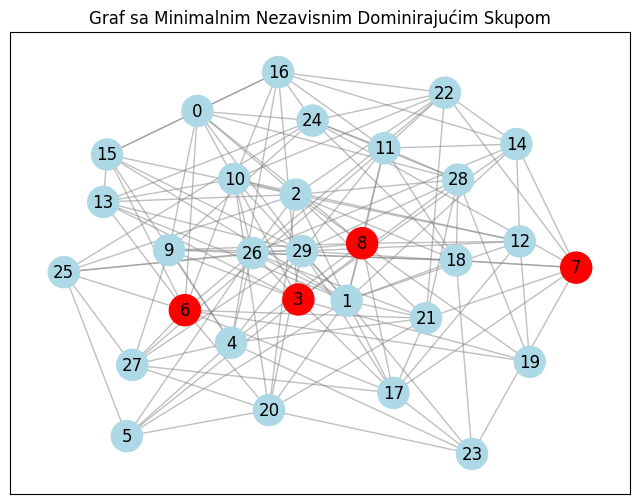

In [304]:
graph = nx.read_gml('tests/test_30_0.3.in')

start_time = time.time()
best_code, best_fitness = vns_main(graph)
print("--- %s seconds ---" % (time.time() - start_time))

best_set = [i for i, included in enumerate(best_code) if included]
print("Minimum Independent Dominating Set:", best_set)
print("Fitness (1 / length of the set):", best_fitness)

draw_graph(graph, best_code)